In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import torch
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline

In [2]:
df = pd.read_csv('compiled_data.csv')
df['ww_date'] = pd.to_datetime(df['ww_date'],format='%Y-%m-%d')
df['sampling_week'] = pd.to_datetime(df['sampling_week'],format='%Y-%m-%d')
df['case_date'] = pd.to_datetime(df['case_date'],format='%Y-%m-%d')

# filter out wwtp ids that do not have null values
wwtp_id_li = list(df['wwtp_id'].unique())
wwtp_id_null_li = []
wwtp_id_full_li = []
county_fips_full_li = []
for wwtp_id in wwtp_id_li:
    # temp_df = df[df['wwtp_id']==wwtp_id]
    if df[df['wwtp_id']==wwtp_id].isnull().values.any():
        wwtp_id_null_li.append(wwtp_id)
    else:
        wwtp_id_full_li.append(wwtp_id)
        county_fips_full_li.append(df[df['wwtp_id']==wwtp_id]['county_fips'].unique()[0])
county_fips_full_li = [*set(county_fips_full_li)] # remove duplicates

In [4]:
def optimization(wwtp_id,sample_df):
    print('wwtp_id: ', wwtp_id)
    # part of the whole process for each wwtp_id: optimize for sm, optimize for lt, and then optimize for rd. After that, loop and compile into a table
    sm_tensor = torch.tensor(1,dtype=float,requires_grad=True)
    lt_arr = np.arange(15,dtype=int) # lagging 0-14 days
    rd_arr = np.arange(0.3,0.501,0.001) # decay rate from 0.300 to 0.500

    # Vector preparation of cases, t, target, and normalized target
    cases_tensor = torch.from_numpy(sample_df['cases'].values)
    cases_tensor = torch.unsqueeze(cases_tensor,dim=-1)
    t_li = []
    start = sample_df['ww_date'].min()
    for ind,val in sample_df['ww_date'].items():
        t_li.append((val-start).days)
    t_tensor = torch.from_numpy(np.array(t_li,dtype=int))
    t_tensor = torch.unsqueeze(t_tensor,dim=-1)
    target_tensor = torch.from_numpy((sample_df['pcr_conc_gc/cap/d']*sample_df['population_served']).to_numpy())
    target_rng_tensor = torch.max(target_tensor)-torch.min(target_tensor) 
    target_norm_tensor = target_tensor/target_rng_tensor # min-max scaling of the target tensor


    # Pytorch optimization of sm
    def sm_mse(pred_tensor,target_norm_tensor):
        loss = torch.tensor([0.],requires_grad=True)
        for i in range(len(pred_tensor)):
            loss = loss + (torch.sum(torch.diag(torch.fliplr(pred_tensor),(len(pred_tensor)-1-i)))-target_norm_tensor[i])**2
        return loss/len(pred_tensor)

    epochs = 200
    lr = 0.001
    rd = 0.386 # fix rd to optimize sm
    sm_loss, sm = 1e29, None
    for i in range(epochs):
        pred_tensor = cases_tensor@(sm_tensor*torch.pow((1-torch.tensor(rd,dtype=float)),t_tensor.T))
        loss = sm_mse(pred_tensor,target_norm_tensor)
        loss.backward()
        with torch.no_grad():
            sm_tensor -= sm_tensor.grad*lr
            sm_tensor.grad.zero_()
            if loss.item()<sm_loss:
                sm_loss = loss.item()
                sm = sm_tensor.detach().numpy()*target_rng_tensor.item()
    # print('After sm optimization: ', sm_loss,"{:.3e}".format(sm))

    # Optimization of lt: fix sm and rd to find the best lt
    pred_tensor = cases_tensor@(torch.tensor(sm/target_rng_tensor.item(),dtype=float)*torch.pow((1-torch.tensor(rd,dtype=float)),t_tensor.T))
    output_tensor = torch.zeros_like(target_norm_tensor)
    for i in range(len(pred_tensor)):
        output_tensor[i] = torch.diagonal(torch.fliplr(pred_tensor),(len(pred_tensor)-1-i)).sum()

    def mse(pred,target):
        diff = pred-target
        return torch.sum(diff*diff)/diff.numel()

    lt_loss, lt = 1e29, None
    for i in lt_arr:
        output_shifted_tensor = output_tensor[i:]
        if i == 0:
            target_nshifted_tensor = target_norm_tensor
        else:
            target_nshifted_tensor = target_norm_tensor[:-i]
        loss = mse(output_shifted_tensor,target_nshifted_tensor).item()
        if loss < lt_loss:
            lt_loss = loss
            lt = i
    # print('After lt optimization', lt_loss, lt)

    # Optimization of rd: fix sm and lt to find the best rd
    rd_loss, rd = 1e29, None
    for j in rd_arr:
        pred_tensor = cases_tensor@(torch.tensor(sm/target_rng_tensor.item(),dtype=float)*torch.pow((1-torch.tensor(j,dtype=float)),t_tensor.T))
        output_tensor = torch.zeros_like(target_norm_tensor)
        for i in range(len(pred_tensor)):
            output_tensor[i] = torch.diagonal(torch.fliplr(pred_tensor),(len(pred_tensor)-1-i)).sum()
        output_shifted_tensor = output_tensor[lt:]
        if lt == 0:
            target_nshifted_tensor = target_norm_tensor
        else:
            target_nshifted_tensor = target_norm_tensor[:-lt]
        loss = mse(output_shifted_tensor,target_nshifted_tensor).item()
        if loss < rd_loss:
            rd_loss = loss
            rd = j    
    # print('After rd optimization', rd_loss, "{:.3f}".format(rd))

    # Final optimization of sm after fixing lt and rd
    def final_mse(pred_tensor,target_norm_tensor,lt):
        f_loss = torch.tensor([0.],requires_grad=True)
        for i in range(len(pred_tensor)-lt):
            f_loss = f_loss + (torch.sum(torch.diag(torch.fliplr(pred_tensor),(len(pred_tensor)-1-i-lt)))-target_norm_tensor[i])**2
        return f_loss/(len(pred_tensor)-lt)

    sm_new_tensor = torch.tensor(sm/target_rng_tensor.item(),dtype=float,requires_grad=True)
    epochs = 200
    lr = 0.001
    final_loss = 1e29
    for i in range(epochs):
        pred_tensor = cases_tensor@(sm_new_tensor*torch.pow((1-torch.tensor(rd,dtype=float)),t_tensor.T))
        f_loss = final_mse(pred_tensor,target_norm_tensor,lt)
        f_loss.backward()
        with torch.no_grad():
            sm_new_tensor -= sm_new_tensor.grad*lr
            sm_new_tensor.grad.zero_()
            if f_loss.item()<final_loss:
                final_loss = f_loss.item()
                sm = sm_new_tensor.detach().numpy()*target_rng_tensor.item()
    print('After final optimization: ', final_loss,"{:.3e}".format(sm), lt, "{:.3f}".format(rd))
    return sm, lt, rd, final_loss

# result_df compilation
# res_df = pd.DataFrame(columns=['wwtp_id','county_fips','county','state','population_served','sample_location','normalization_method','per_capita_flow_rate','start_date','end_date','days','loss','sm','lt','rd','k','half_life'])

res_df = pd.read_csv('results.csv')
res_df['start_date'] = pd.to_datetime(res_df['start_date'],format='%Y-%m-%d')
res_df['end_date'] = pd.to_datetime(res_df['end_date'],format='%Y-%m-%d')

i = 250
error_wwtp_id_li = []
for wwtp_id in wwtp_id_null_li[i:]:
    print(i)
    if (wwtp_id not in [1212,446,383,818,992,1023,675,635,674,462,144,933,932,940,956,469,945,955,938,885,884,909,24,6,25,28,11,7,30,308,118,758,445]):
        try:
            sample_df = df[df['wwtp_id']==wwtp_id].sort_values(by=['ww_date'])
            sm,lt,rd,loss = optimization(wwtp_id,sample_df)
            k = -np.log(1-rd)
            half_life = 0.693/k
            county_fips,county,state,pop,sample_location,normalization_method = sample_df[['county_fips','county','state','population_served','sample_location','normalization_method']].iloc[0]
            per_capita_flow_rate = sample_df['per_capita_flow_rate'].median()
            start_date,end_date = sample_df['ww_date'].iloc[0],sample_df['ww_date'].iloc[-1]
            days = (end_date-start_date).days
            row_to_append = pd.DataFrame({'wwtp_id':[wwtp_id], 'county_fips':[county_fips], 'county':[county], 'state':[state], 'population_served':[pop], 'sample_location':[sample_location], 'normalization_method':[normalization_method],'per_capita_flow_rate':[per_capita_flow_rate], 'start_date':[start_date],'end_date':[end_date],'days':[days],'loss':[loss],'sm':[sm], 'lt':[lt], 'rd':[rd], 'k':[k],'half_life':[half_life]}) 
            res_df = pd.concat([res_df,row_to_append])
        except:
            error_wwtp_id_li.append(wwtp_id)
            print('error wwtp_id: ', wwtp_id, ' at number: ', i)
    i += 1
    # if i>2:
    #     break
    
# import IPython
# IPython.display.Audio('https://api.bossbadi.ml/file/admin/LbkDMB-s.mp3', autoplay=True)

250
wwtp_id:  768
After final optimization:  851174.625 3.317e+16 14 0.500
251
wwtp_id:  555
After final optimization:  0.06463257968425751 2.418e+13 14 0.500
252
wwtp_id:  679
After final optimization:  0.18455494940280914 7.440e+12 8 0.300
253
wwtp_id:  661
After final optimization:  0.02080393023788929 6.761e+12 12 0.355
254
255
wwtp_id:  391
After final optimization:  0.08388867229223251 1.397e+12 9 0.300
256
wwtp_id:  1277
After final optimization:  10525438.0 1.325e+17 14 0.500
257
wwtp_id:  231
After final optimization:  3927588864.0 3.763e+18 14 0.500
258
wwtp_id:  433
After final optimization:  96187.7109375 1.491e+14 14 0.500
259
wwtp_id:  1317
After final optimization:  0.05921076238155365 1.995e+12 14 0.372
260
wwtp_id:  188
After final optimization:  0.014543083496391773 1.257e+12 5 0.367


In [5]:
res_df.to_csv('results.csv',index=False)
len(res_df)

325

In [3]:
res_df = pd.read_csv('results.csv')
res_df['start_date'] = pd.to_datetime(res_df['start_date'],format='%Y-%m-%d')
res_df['end_date'] = pd.to_datetime(res_df['end_date'],format='%Y-%m-%d')

In [6]:
failed_to_converge_li = [1212,446,383,818,992,1023,675,635,674,462,144,933,932,940,956,469,945,955,938,885,884,909,24,6,25,28,11,7,30,308,118,758,445]
for ind,val in res_df.iterrows():
    if val['loss'] > 10: 
        failed_to_converge_li.append(val['wwtp_id'])

In [8]:
len(failed_to_converge_li)/len(wwtp_id_li)

0.29608938547486036

In [7]:
res_df

,wwtp_id,county_fips,county,state,population_served,sample_location,normalization_method,per_capita_flow_rate,start_date,end_date,days,loss,sm,lt,rd,k,half_life
0,1382,4013,Maricopa,Arizona,50000,Treatment plant,flow-population,10162.706922,2022-07-30,2022-12-12,135,3.481739e-02,3.519948e+14,14,0.300,0.356675,1.942946
1,1383,4013,Maricopa,Arizona,2400000,Treatment plant,flow-population,776.106769,2022-07-30,2022-12-12,135,1.158007e+12,1.993325e+21,14,0.500,0.693147,0.999788
2,1334,4013,Maricopa,Arizona,150000,Treatment plant,flow-population,1216.112587,2022-07-17,2022-12-12,148,5.899417e-02,1.680067e+13,14,0.376,0.471605,1.469450
3,1327,4015,Mohave,Arizona,30000,Treatment plant,flow-population,1092.726504,2022-07-13,2022-12-14,154,2.270681e-02,2.518150e+12,8,0.340,0.415515,1.667808
4,1540,5009,Boone,Arkansas,14000,Treatment plant,flow-population,404.939999,2022-09-26,2022-12-14,79,8.604906e-02,1.032213e+12,0,0.371,0.463624,1.494746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1277,55025,Dane,Wisconsin,360000,Treatment plant,flow-population,928.363881,2022-06-21,2022-12-13,175,1.052544e+07,1.325246e+17,14,0.500,0.693147,0.999788
0,231,55025,Dane,Wisconsin,345000,Treatment plant,flow-population,370.183070,2022-01-07,2022-12-13,340,3.927589e+09,3.763360e+18,14,0.500,0.693147,0.999788
0,433,55073,Marathon,Wisconsin,42350,Treatment plant,flow-population,93.056265,2022-01-08,2022-12-10,336,9.618771e+04,1.490614e+14,14,0.500,0.693147,0.999788
0,1317,56037,Sweetwater,Wyoming,12000,Treatment plant,flow-population,478.687744,2022-07-10,2022-12-13,156,5.921076e-02,1.995398e+12,14,0.372,0.465215,1.489633


In [2]:
df = pd.read_csv('compiled_data.csv')
df['ww_date'] = pd.to_datetime(df['ww_date'],format='%Y-%m-%d')
df['sampling_week'] = pd.to_datetime(df['sampling_week'],format='%Y-%m-%d')
df['case_date'] = pd.to_datetime(df['case_date'],format='%Y-%m-%d')

# filter out wwtp ids that do not have null values
wwtp_id_li = list(df['wwtp_id'].unique())
wwtp_id_null_li = []
wwtp_id_full_li = []
county_fips_full_li = []
for wwtp_id in wwtp_id_li:
    # temp_df = df[df['wwtp_id']==wwtp_id]
    if df[df['wwtp_id']==wwtp_id].isnull().values.any():
        wwtp_id_null_li.append(wwtp_id)
    else:
        wwtp_id_full_li.append(wwtp_id)
        county_fips_full_li.append(df[df['wwtp_id']==wwtp_id]['county_fips'].unique()[0])
county_fips_full_li = [*set(county_fips_full_li)] # remove duplicates

wwtp_id = 1529
sample_df = df[df['wwtp_id']==wwtp_id].sort_values(by=['ww_date'])
sample_df

,wwtp_id,county_fips,county,state,population_served,ww_date,flow_rate,per_capita_flow_rate,sample_location,pcr_conc_gc/cap/d,normalization_method,sampling_week,pcr_conc_gc/mL,case_date,cases_per_100k,cases
57860,1529,42063,Indiana,Pennsylvania,28809,2022-07-04,5.760737e+08,19996.311165,Treatment plant,6.122992e+08,flow-population,2020-07-01,30.62061,2022-07-04,11.044823,3.181903
57861,1529,42063,Indiana,Pennsylvania,28809,2022-07-05,6.336576e+08,21995.125373,Treatment plant,6.735042e+08,flow-population,2020-07-01,30.62061,2022-07-05,11.044823,3.181903
57771,1529,42063,Indiana,Pennsylvania,28809,2022-07-06,6.905209e+08,23968.930219,Treatment plant,7.339433e+08,flow-population,2020-07-01,30.62061,2022-07-06,11.044823,3.181903
57862,1529,42063,Indiana,Pennsylvania,28809,2022-07-07,7.459262e+08,25892.123710,Treatment plant,7.928326e+08,flow-population,2020-07-01,30.62061,2022-07-07,11.044823,3.181903
57863,1529,42063,Indiana,Pennsylvania,28809,2022-07-08,7.991358e+08,27739.103852,Treatment plant,8.493883e+08,flow-population,2020-07-01,30.62061,2022-07-08,11.044823,3.181903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57857,1529,42063,Indiana,Pennsylvania,28809,2022-12-03,6.395073e+06,221.981770,Treatment plant,4.307103e+08,flow-population,2020-11-25,1940.29593,2022-12-03,6.626894,1.909142
57926,1529,42063,Indiana,Pennsylvania,28809,2022-12-04,6.720070e+06,233.262885,Treatment plant,4.525990e+08,flow-population,2020-11-25,1940.29593,2022-12-04,9.005779,2.594475
57858,1529,42063,Indiana,Pennsylvania,28809,2022-12-05,1.298236e+07,450.635711,Treatment plant,4.792560e+08,flow-population,2020-12-02,1063.51089,2022-12-05,9.005779,2.594475
57927,1529,42063,Indiana,Pennsylvania,28809,2022-12-06,1.382335e+07,479.827419,Treatment plant,5.103017e+08,flow-population,2020-12-02,1063.51089,2022-12-06,9.005779,2.594475


In [54]:
print(wwtp_id_null_li)

[1333, 1464, 1394, 1490, 1491, 501, 1212, 808, 715, 590, 1271, 1537, 1536, 1548, 1442, 1542, 1546, 1543, 1444, 446, 1472, 1461, 1465, 1462, 1509, 1685, 564, 1173, 724, 1668, 88, 1720, 1288, 461, 1199, 1019, 778, 1219, 779, 1690, 211, 1694, 1693, 383, 1409, 356, 1709, 1684, 357, 1230, 793, 1676, 1678, 1679, 1680, 570, 1687, 1290, 161, 686, 1079, 1196, 832, 1163, 486, 1502, 1501, 670, 671, 669, 1715, 1686, 1702, 511, 574, 1145, 684, 1109, 1221, 1337, 1208, 1204, 1203, 790, 798, 818, 992, 1023, 675, 638, 982, 632, 635, 639, 682, 674, 683, 637, 636, 641, 546, 628, 462, 678, 1281, 1273, 1319, 1318, 1267, 765, 772, 1293, 1681, 1289, 1314, 105, 544, 1447, 1449, 1496, 1303, 807, 1305, 1292, 1300, 1304, 1299, 472, 787, 833, 1116, 1107, 1229, 347, 65, 507, 475, 560, 1206, 1260, 1285, 1268, 1278, 1262, 1284, 1261, 470, 1393, 1312, 1411, 663, 703, 1082, 777, 285, 1706, 497, 402, 1385, 1291, 853, 854, 1386, 1306, 1021, 719, 836, 144, 537, 539, 1463, 1471, 36, 831, 1264, 769, 933, 932, 940, 956, 469

In [7]:
wwtp_id = 1212
sample_df = df[df['wwtp_id']==wwtp_id].sort_values(by=['ww_date'])
sample_df

,wwtp_id,county_fips,county,state,population_served,ww_date,flow_rate,per_capita_flow_rate,sample_location,pcr_conc_gc/cap/d,normalization_method,sampling_week,pcr_conc_gc/mL,case_date,cases_per_100k,cases
1189,1212,4013,Maricopa,Arizona,17280,2022-01-04,NaN,NaN,Before treatment plant,1.381619e+08,flow-population,NaT,NaN,2022-01-04,140.015742,0.159740
1999,1212,4013,Maricopa,Arizona,17280,2022-01-04,NaN,NaN,Before treatment plant,3.403378e+07,flow-population,NaT,NaN,2022-01-04,140.015742,0.159740
1326,1212,4013,Maricopa,Arizona,17280,2022-01-04,NaN,NaN,Before treatment plant,2.892262e+07,flow-population,NaT,NaN,2022-01-04,140.015742,0.159740
1595,1212,4013,Maricopa,Arizona,17280,2022-01-04,NaN,NaN,Before treatment plant,3.680667e+07,flow-population,NaT,NaN,2022-01-04,140.015742,0.159740
909,1212,4013,Maricopa,Arizona,17280,2022-01-04,NaN,NaN,Before treatment plant,2.873502e+08,flow-population,NaT,NaN,2022-01-04,140.015742,0.159740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,1212,4013,Maricopa,Arizona,17280,2022-09-29,7.365154e+05,42.622416,Before treatment plant,7.624833e+06,flow-population,2022-09-28,178.892546,2022-09-29,5.051294,0.005763
1863,1212,4013,Maricopa,Arizona,17280,2022-09-29,-1.577761e+05,-9.130563,Before treatment plant,-1.633390e+06,flow-population,2022-09-28,178.892546,2022-09-29,5.051294,0.005763
908,1212,4013,Maricopa,Arizona,17280,2022-09-29,4.277075e+06,247.515918,Before treatment plant,4.427875e+07,flow-population,2022-09-28,178.892546,2022-09-29,5.051294,0.005763
1998,1212,4013,Maricopa,Arizona,17280,2022-09-29,-4.968957e+05,-28.755538,Before treatment plant,-5.144151e+06,flow-population,2022-09-28,178.892546,2022-09-29,5.051294,0.005763


In [8]:
sample_df['per_capita_flow_rate'].median()

273.7059496649872

In [24]:
# Demo using hypothetic data

torch.autograd.set_detect_anomaly(True)

def mse(pred,target):
    loss = torch.tensor([0.],requires_grad=True)
    for i in range(len(pred)):
        loss = loss + (torch.sum(torch.diag(torch.fliplr(pred),(len(pred)-1-i)))-target[i])**2
    return loss

cases = torch.tensor([[1],[2],[3]],dtype=float)
t = torch.tensor([[0],[1],[2]],dtype=int)
rd = torch.tensor(0.5,dtype=float)
sm = torch.tensor(10,dtype=float,requires_grad=True)
target = torch.tensor([4,10,17],dtype=float)
rng = (torch.max(target)-torch.min(target))
target_norm = target/rng

epochs = 200
lr = 0.001
best_mse, best_sm = 1e3, None

for i in range(epochs):
    pred = cases@(sm*torch.pow((1-rd),t.T))
    loss = mse(pred,target_norm)
    loss.backward()
    with torch.no_grad():
        sm -= sm.grad*lr
        sm.grad.zero_()
        if loss.item()<best_mse:
            best_mse = loss.item()
            best_sm = (sm*rng).item()
    if i%10 == 0:
        print(f"Epoch {i}/{epochs}: Loss = {loss.item()}, sm = {sm.item()*rng.item()}, rd = {rd}")

Epoch 0/200: Loss = 2377.877197265625, sm = 123.62125, rd = 0.5
Epoch 10/200: Loss = 841.2890625, sm = 75.15185849518052, rd = 0.5
Epoch 20/200: Loss = 297.6466979980469, sm = 46.3218029181119, rd = 0.5
Epoch 30/200: Loss = 105.30691528320312, sm = 29.17341135032794, rd = 0.5
Epoch 40/200: Loss = 37.257415771484375, sm = 18.97338476432494, rd = 0.5
Epoch 50/200: Loss = 13.181612968444824, sm = 12.906311829588304, rd = 0.5
Epoch 60/200: Loss = 4.663632869720459, sm = 9.29755907928415, rd = 0.5
Epoch 70/200: Loss = 1.6499857902526855, sm = 7.151038582016864, rd = 0.5
Epoch 80/200: Loss = 0.5837622880935669, sm = 5.874267751762486, rd = 0.5
Epoch 90/200: Loss = 0.20653414726257324, sm = 5.114832304924789, rd = 0.5
Epoch 100/200: Loss = 0.0730714425444603, sm = 4.663112870044951, rd = 0.5
Epoch 110/200: Loss = 0.02585255727171898, sm = 4.394425849050828, rd = 0.5
Epoch 120/200: Loss = 0.009146591648459435, sm = 4.234608250611876, rd = 0.5
Epoch 130/200: Loss = 0.0032360495533794165, sm = 4

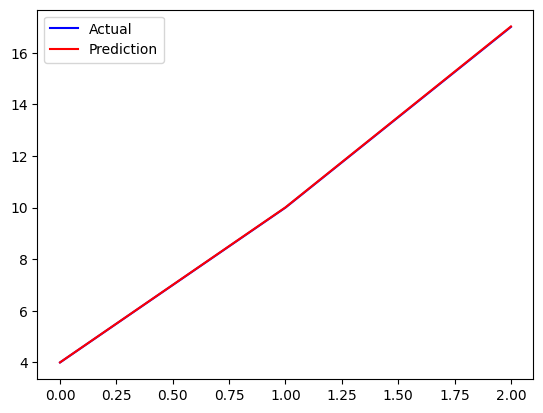

In [29]:
pred = cases@((best_sm)*torch.pow((1-rd),t.T))

target = torch.tensor([4,10,17],dtype=float)
output = torch.zeros_like(target,dtype=float)
for i in range(len(pred)):
    output[i] = torch.sum(torch.diag(torch.fliplr(pred),(len(pred)-1-i)))
plt.plot(t,target,'b-',label='Actual')
plt.plot(t,output,'r-',label='Prediction')
plt.legend()